In [1]:
# Imports.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data_utils import CSVData
from dynamical_systems import linear_system, andronov_hopf, vec_roessler_attractor
from nets import RK4N, RK4
from torch.utils.data.sampler import SubsetRandomSampler
from utils import euler, plot_phase_portrait, plot_3d_trajectory, train_valid_loader

# 1. Linear system.

In [2]:
# Choose your network parameters.
input_size=2
num_param=1
hidden_size=20
h=1
num_hidden_layers=2

# Initialise the model.
model = RK4N(input_size, num_param, hidden_size, h, num_hidden_layers)

In [3]:
# Load data.
dataset = CSVData(csv_file_path='first_model.csv')
train_loader, val_loader = train_valid_loader(dataset)

In [4]:
# Loss & optimizer.
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

# Losses
train_losses = []
val_losses = []

for epoch in range(10):  # loop over the dataset multiple times

    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, params, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs, params)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, params, labels = data

            # forward + loss 
            outputs = model(inputs, params)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print('[Epoch: %d] training loss: %.9f  validation loss: %.9f' %
            (epoch + 1, train_loss,val_loss))
    
            

print('Finished Training')

[Epoch: 1] training loss: 0.008283288  validation loss: 0.000028764
[Epoch: 2] training loss: 0.000016267  validation loss: 0.000012222
[Epoch: 3] training loss: 0.000011711  validation loss: 0.000009573
[Epoch: 4] training loss: 0.000004838  validation loss: 0.000003186
[Epoch: 5] training loss: 0.000003385  validation loss: 0.000003589
[Epoch: 6] training loss: 0.000003634  validation loss: 0.000003993
[Epoch: 7] training loss: 0.000003908  validation loss: 0.000003718
[Epoch: 8] training loss: 0.000003806  validation loss: 0.000003965
[Epoch: 9] training loss: 0.000004062  validation loss: 0.000004191
[Epoch: 10] training loss: 0.000004107  validation loss: 0.000004077
Finished Training


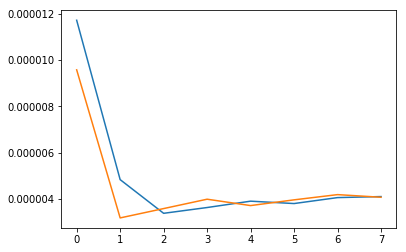

In [5]:
plt.plot(train_losses[2:])
plt.plot(val_losses[2:])

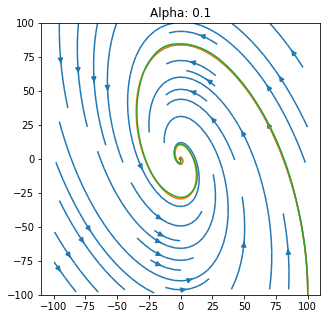

In [6]:
alpha = 0.1

plot_phase_portrait(linear_system, alpha, model, 100, [100,-100])

# 2. Andronov-Hopf system

In [2]:
# Choose your network parameters.
input_size=2
num_param=1
hidden_size=64
h=1
num_hidden_layers=3

# Initialise the model.
model = RK4N(input_size, num_param, hidden_size, h, num_hidden_layers)

In [3]:
# Load data.
dataset = CSVData(csv_file_path='second_model.csv')
train_loader, val_loader = train_valid_loader(dataset, bs=250)

In [4]:
# Loss & optimizer.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

# Losses
train_losses = []
val_losses = []

for epoch in range(10):  # loop over the dataset multiple times

    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, params, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs, params)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, params, labels = data

            # forward + loss 
            outputs = model(inputs, params)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print('[Epoch: %d] training loss: %.9f  validation loss: %.9f' %
            (epoch + 1, train_loss,val_loss))
    
            

print('Finished Training')

[Epoch: 1] training loss: 0.000182765  validation loss: 0.000041835
[Epoch: 2] training loss: 0.000025636  validation loss: 0.000017487
[Epoch: 3] training loss: 0.000013423  validation loss: 0.000010915
[Epoch: 4] training loss: 0.000008856  validation loss: 0.000007697
[Epoch: 5] training loss: 0.000006751  validation loss: 0.000006100
[Epoch: 6] training loss: 0.000005470  validation loss: 0.000005830
[Epoch: 7] training loss: 0.000004478  validation loss: 0.000004315
[Epoch: 8] training loss: 0.000003852  validation loss: 0.000003970
[Epoch: 9] training loss: 0.000003431  validation loss: 0.000003436
[Epoch: 10] training loss: 0.000003239  validation loss: 0.000003638
Finished Training


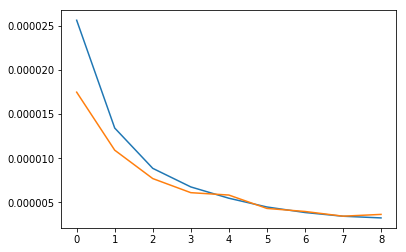

In [6]:
plt.plot(train_losses[1:])
plt.plot(val_losses[1:])

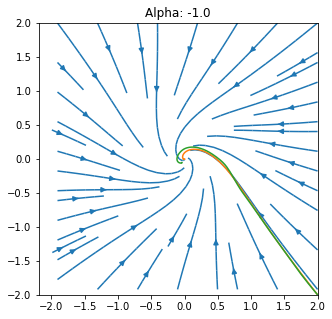

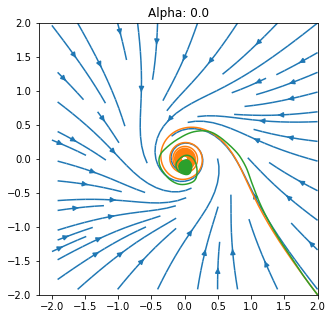

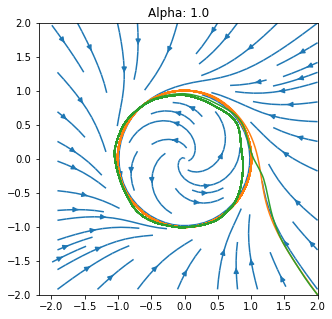

In [7]:
plot_phase_portrait(andronov_hopf, -1.0, model, 2, [2,-2])
plot_phase_portrait(andronov_hopf,  0.0, model, 2, [2,-2])
plot_phase_portrait(andronov_hopf,  1.0, model, 2, [2,-2])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Text(0, 0.5, "x (pedestrian's coordinate)")

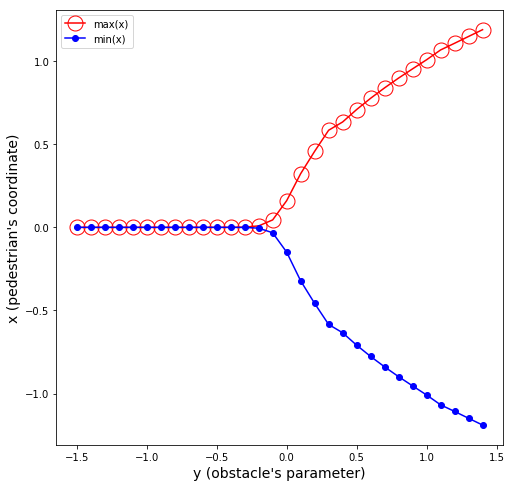

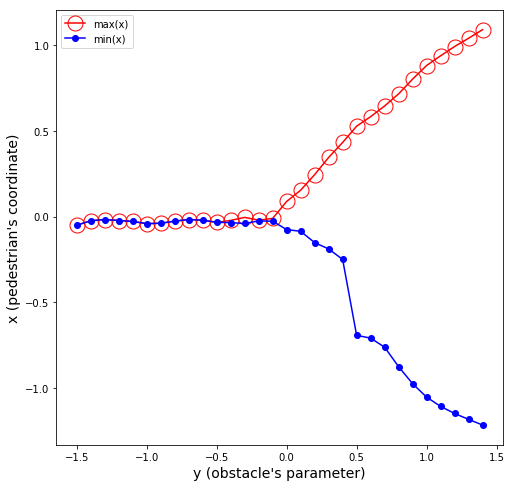

In [23]:
# Bifurcation
from scipy.integrate import solve_ivp


alphas = []
maxs_model= []
mins_model= []
maxs_true= []
mins_true= []
alpha = -1.5
x0 = [2,-2]
for i in range(30):
    trajectory = []
    y = x0
    
    for j in range(20000):
        trajectory.append(y)
        y = model(torch.FloatTensor(y).unsqueeze(0), torch.FloatTensor([alpha]).unsqueeze(0)).tolist()[0]
    trajectory = np.asarray(trajectory).T
    tspan = (0., 200.)
    teval = np.arange(tspan[0], tspan[1], 0.01)
    sol = solve_ivp(lambda t, x: andronov_hopf(x[0], x[1], alpha), tspan, x0, t_eval=teval)
    maxs_model.append(np.max(trajectory[0][1800:]))
    mins_model.append(np.min(trajectory[0][1800:]))
    maxs_true.append(np.max(sol.y[0][1800:]))
    mins_true.append(np.min(sol.y[0][1800:]))
    alphas.append(alpha)
    alpha += 0.1
    print(i)

plt.figure(figsize=(8,8))
plt.plot(alphas, maxs_true, 'ro', linestyle='-', mfc='none', markersize=15) 
plt.plot(alphas, mins_true, 'bo', linestyle='-') 
plt.title('True System')
plt.legend(['max(x)', 'min(x)'])
plt.xlabel("alpha", fontsize=14)
plt.ylabel("x", fontsize=14)

plt.figure(figsize=(8,8))
plt.plot(alphas, maxs_model, 'ro', linestyle='-', mfc='none', markersize=15) 
plt.plot(alphas, mins_model, 'bo', linestyle='-') 
plt.title('Approximated System')
plt.legend(['max(x)', 'min(x)'])
plt.xlabel("alpha", fontsize=14)
plt.ylabel("x", fontsize=14)

Text(0, 0.5, 'x')

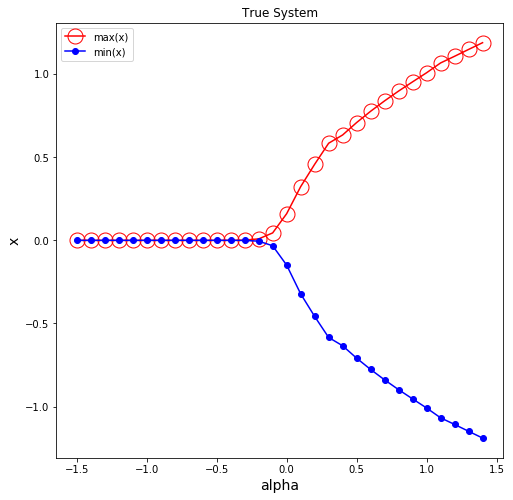

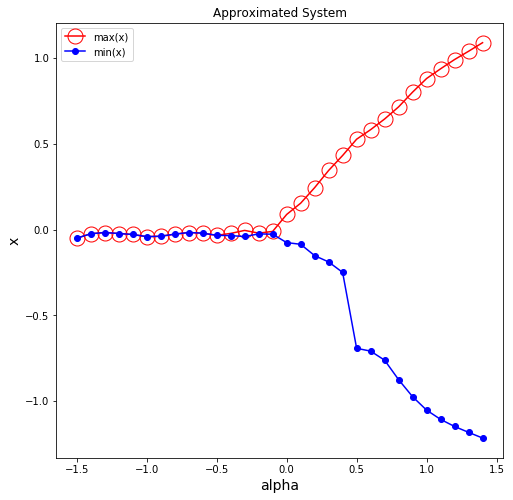

In [24]:
plt.figure(figsize=(8,8))
plt.plot(alphas, maxs_true, 'ro', linestyle='-', mfc='none', markersize=15) 
plt.plot(alphas, mins_true, 'bo', linestyle='-') 
plt.title('True System')
plt.legend(['max(x)', 'min(x)'])
plt.xlabel("alpha", fontsize=14)
plt.ylabel("x", fontsize=14)

plt.figure(figsize=(8,8))
plt.plot(alphas, maxs_model, 'ro', linestyle='-', mfc='none', markersize=15) 
plt.plot(alphas, mins_model, 'bo', linestyle='-') 
plt.title('Approximated System')
plt.legend(['max(x)', 'min(x)'])
plt.xlabel("alpha", fontsize=14)
plt.ylabel("x", fontsize=14)

# 3. Roessler attractor

In [2]:
# Choose your network parameters.
input_size=3
num_param=1
hidden_size=200
h=1
num_hidden_layers=3

# Initialise the model.
model = RK4N(input_size, num_param, hidden_size, h, num_hidden_layers)

In [3]:
# Load data.
dataset = CSVData(csv_file_path='third_model.csv', input_size=3)
train_loader, val_loader = train_valid_loader(dataset, bs=1000)

In [17]:
# Loss & optimizer.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0)

# Losses
train_losses = []
val_losses = []

for epoch in range(3):  # loop over the dataset multiple times

    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        running_loss = 0.0
        # get the inputs; data is a list of [inputs, labels]
        inputs, params, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs, params)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.9f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, params, labels = data

            # forward + loss 
            outputs = model(inputs, params)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print('[Epoch: %d] training loss: %.9f  validation loss: %.9f' %
            (epoch + 1, train_loss,val_loss))
    
            

print('Finished Training')

[1,   200] loss: 0.000007389
[1,   400] loss: 0.000005379
[1,   600] loss: 0.000001316
[1,   800] loss: 0.000005170
[1,  1000] loss: 0.000003255
[1,  1200] loss: 0.000100803
[1,  1400] loss: 0.000003473
[1,  1600] loss: 0.000002116
[1,  1800] loss: 0.000004176
[1,  2000] loss: 0.000011597
[1,  2200] loss: 0.000078496
[1,  2400] loss: 0.000013012
[1,  2600] loss: 0.000004319
[1,  2800] loss: 0.000010433
[1,  3000] loss: 0.000005605
[1,  3200] loss: 0.000003927
[1,  3400] loss: 0.000026277
[1,  3600] loss: 0.000002080
[1,  3800] loss: 0.000018766
[1,  4000] loss: 0.000004238
[1,  4200] loss: 0.000014200
[1,  4400] loss: 0.000014606
[1,  4600] loss: 0.000002530
[1,  4800] loss: 0.000007077
[Epoch: 1] training loss: 0.002621359  validation loss: 0.001843571
[2,   200] loss: 0.000009235
[2,   400] loss: 0.000004572
[2,   600] loss: 0.000003094
[2,   800] loss: 0.000003080
[2,  1000] loss: 0.000167901
[2,  1200] loss: 0.000003906
[2,  1400] loss: 0.000021649
[2,  1600] loss: 0.000007806
[2, 

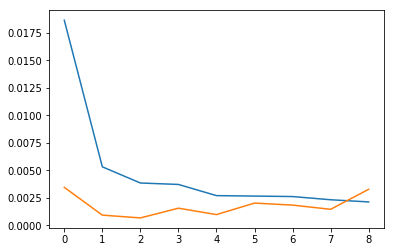

In [18]:
plt.plot(train_losses[0:])
plt.plot(val_losses[0:])

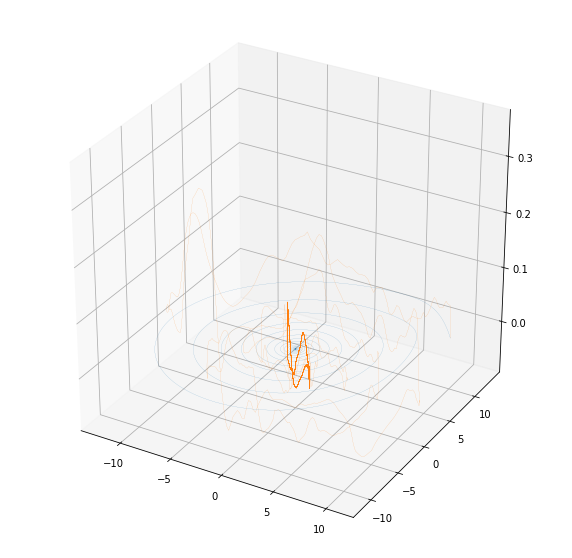

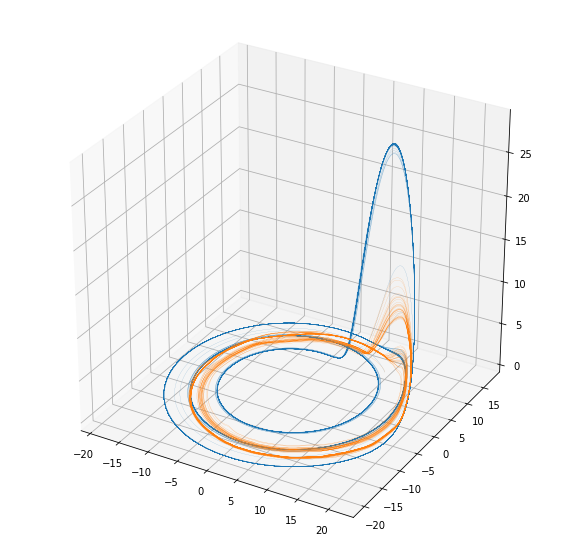

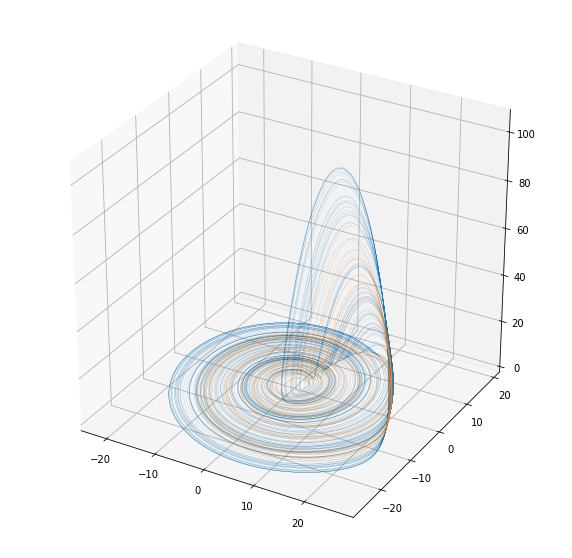

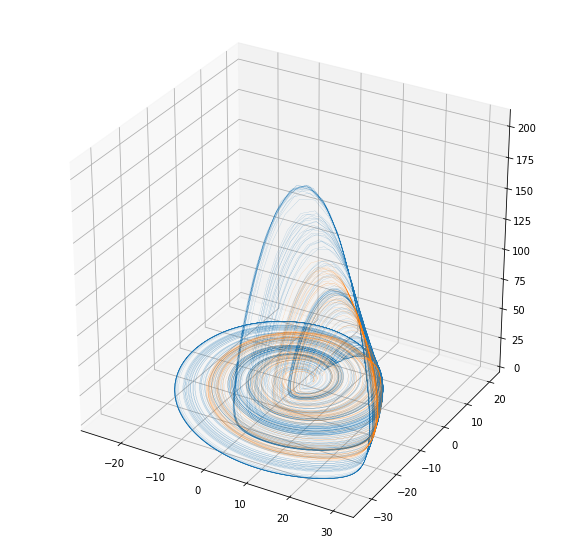

In [19]:
a_s = np.array([-0.1, 0.1, 0.2, 0.3])
for a in a_s:
    plot_3d_trajectory(vec_roessler_attractor, a, model, np.array([10,10,0]))

50000


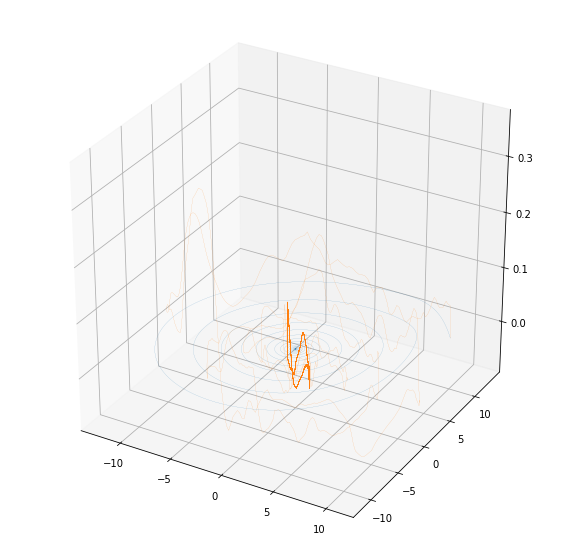

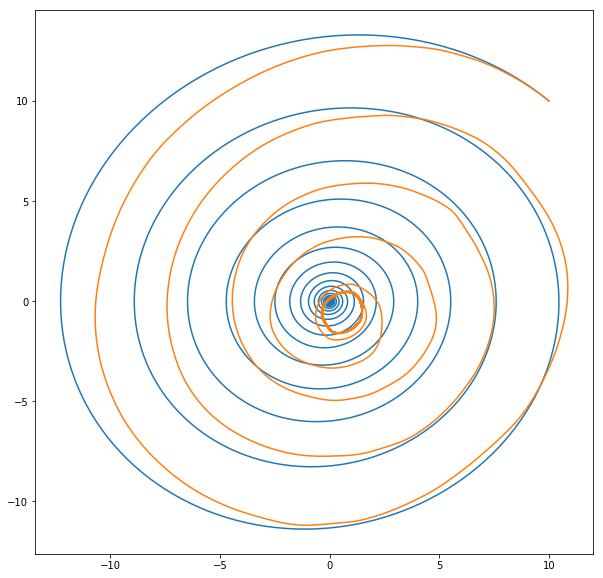

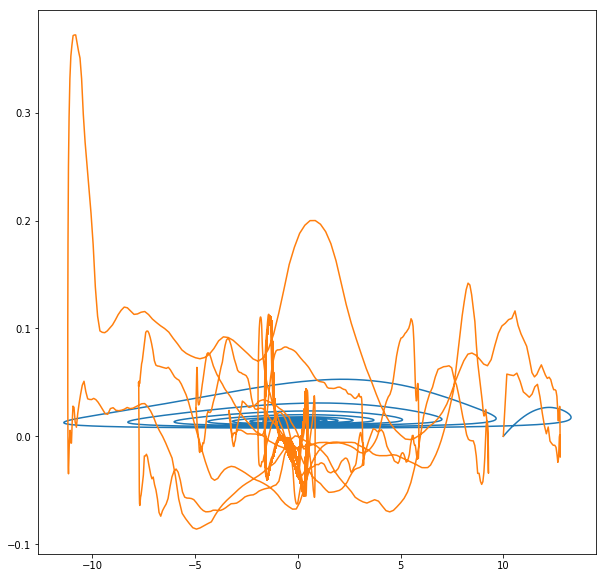

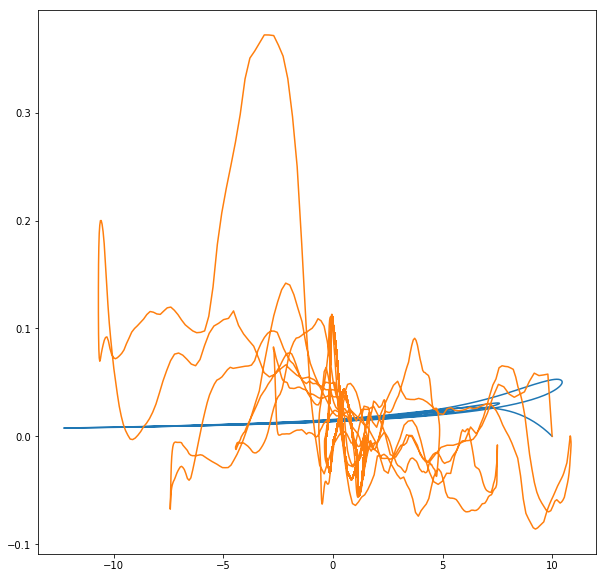

In [24]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

trajectory = []
x0= np.array([10,10,0])
y = x0
param=-0.1
for i in range(50000):
    trajectory.append(y)
    y = model(torch.FloatTensor(y).unsqueeze(0), torch.FloatTensor([param]).unsqueeze(0)).tolist()[0]
trajectory = np.asarray(trajectory).T
tspan = (0., 1000.)
teval = np.arange(tspan[0], tspan[1], 0.02)
sol = solve_ivp(lambda t, x: vec_roessler_attractor(x, param), tspan, x0, t_eval=teval)
print(len(sol.y[0]))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2], lw=0.1)
ax.plot(trajectory[0], trajectory[1], trajectory[2], lw=0.1)
plt.show()
fig = plt.figure(figsize=(10.,10.))
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.plot(trajectory[0], trajectory[1])
fig = plt.figure(figsize=(10.,10.))
ax = fig.add_subplot(111)
ax.plot(sol.y[1], sol.y[2])
ax.plot(trajectory[1], trajectory[2])
fig = plt.figure(figsize=(10.,10.))
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[2])
ax.plot(trajectory[0], trajectory[2])

In [15]:
trajectory

array([[10.        ,  9.70019531,  9.42552567, ...,  0.01059086,
         0.01059086,  0.01059086],
       [10.        , 10.27109623, 10.52297306, ...,  1.71572125,
         1.71572125,  1.71572125],
       [ 0.        ,  0.04342955,  0.04109633, ..., -0.04524262,
        -0.04524262, -0.04524262]])